## 📖 **Introduction**

In today’s customer-centric aviation industry, maintaining a strong reputation and delivering high-quality service are essential for airlines to stay competitive. One powerful way to assess and improve service is by analyzing customer feedback found on public platforms like [AirlineQuality.com](https://www.airlinequality.com). These platforms contain thousands of reviews — rich in insight, yet unstructured and hard to interpret without the help of data science.

This project is part of **Task 0** from the **British Airways Data Science Virtual Internship** on [Forage](https://www.theforage.com/simulations/british-airways/data-science-yqoz), simulating a real-world scenario where the airline wants to mine online reviews to uncover patterns, sentiments, and key areas of customer satisfaction or dissatisfaction.

The project also serves as a capstone-style exercise to apply practical skills gained from completing multiple **NLP-focused courses** within the [Machine Learning Scientist career track on DataCamp](https://app.datacamp.com/learn/career-tracks/machine-learning-scientist-with-python).

---

### 🎯 **Project Goals**

#### 🧑🏽‍💼 Business Goals

* Understand what British Airways is doing well and where customer satisfaction is low.
* Identify key pain points in the travel experience based on recurring themes in reviews.
* Generate actionable insights to inform service improvements, customer communication, and brand strategy.
* Present findings in a clear and concise 1–2 slide summary for decision-makers.

#### 📊 Data Science Goals

* Collect and structure raw textual review data from a public website using web scraping.
* Clean and preprocess unstructured text using standard NLP techniques.
* Apply sentiment analysis and topic modeling to detect themes and emotional tones.
* Visualize and interpret review content to extract meaning and trends.
* Translate insights into business-oriented recommendations.

---

### 🛠️ **Tools & Technologies**

| Area                         | Tools                                                             |
| ---------------------------- | ----------------------------------------------------------------- |
| **Web Scraping**             | `requests`, `BeautifulSoup`                                       |
| **Data Handling**            | `pandas`, `numpy`                                                 |
| **Text Preprocessing**       | `nltk`, `spaCy`                                                   |
| **Sentiment Analysis**       | `TextBlob`, `VADER`                                               |
| **Keyword & Topic Modeling** | `CountVectorizer`, `TfidfVectorizer`, `LatentDirichletAllocation` |
| **Visualization**            | `matplotlib`, `seaborn`, `WordCloud`                              |
| **Presentation**             | Canva (or optionallay PowerPoint, Google slides)                  |

### Importing Libraries and Loading Dataset

In [126]:
# Miscellaneous
from pathlib import Path

# Base directory = location of the current script or notebook
base_dir = Path().resolve()

In [127]:
# Data Wrangling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import re
import nltk
# NLTK data path
nltk_data_path = base_dir / "nltk_data"
nltk.data.path.append(str(nltk_data_path))
import spacy

# Text Analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from collections import Counter

print("✅ All packages successfully loaded!")

✅ All packages successfully loaded!


In [128]:
default_stopwords = text.ENGLISH_STOP_WORDS

In [129]:
# Load the custom lexicon manually
def load_custom_vader_lexicon(path):
    lexicon = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            word, measure = line.strip().split('\t')[0:2]
            lexicon[word] = float(measure)
    return lexicon

# Create an uninitialized instance (bypass __init__)
sia = SentimentIntensityAnalyzer.__new__(SentimentIntensityAnalyzer)

# Vader lexicon path
vader_lexicon_path = nltk_data_path / "sentiment" / "lexicon" / "vader_lexicon.txt"

# Inject required attributes manually
sia.lexicon = load_custom_vader_lexicon(str(vader_lexicon_path))

# Copy default constants
from nltk.sentiment.vader import VaderConstants
sia.constants = VaderConstants()

# Now test
print(sia.polarity_scores("I love how clean and comfortable the flight was."))


{'neg': 0.0, 'neu': 0.329, 'pos': 0.671, 'compound': 0.8807}


In [130]:
# Loading dataset
raw_reviews_path = base_dir / "data" / "british_airways_reviews.csv"

df_reviews = pd.read_csv(raw_reviews_path)

In [131]:
df_reviews.sample(20)

,reviews
612,"✅ Trip Verified | The A80 is a wonderful aircraft - quieter than any other aircraft I've flown. Flight was delayed arriving at Vancouver from London, which meant that departing flight from Vancouver was also delayed. Passengers waited almost 90 minutes at London Terminal 5 for baggage to arrive - excuse given by BA ground staff was that the baggage staff are ""very busy right now"" and our baggage will arrive ""soon."" Onboard amenities and services quite disappointing. Seat was reasonably spacious but did not offer sufficient back support. Meal sizes and portions considerably smaller than when I last flown with BA - a tiny ham and cheese croissant for breakfast. Cabin crew noticeably absent from cabin during flight - no offer of water, juice, or other beverages during the flight. Overall, a fairly disappointing experience with BA."
3061,"I selected British Airways on this trip, ahead of Air China who I've used a few times from Beijing. What a mistake, because despite some of the problems with Chinese airlines, they offer a far superior service to British Airways. The cabin, seats etc were dirty and claustrophobic on this British Airways flight, and I bitterly regret my patriotism in selected them for this trip. Food is basically on a par with many Asian airlines Economy class standards, and you need to be very cautious about believing any of the marketing rubbish that British Airways provide in different areas. This is not a premium experience, and was a true waste of money. Staff were on another planet as far as service was concerned - abrupt, unsmiling and intent on getting service over as quickly as possible, before they retired to gossip loudly in the galley. Using the call button was a waste of time midflight, I guess they were all resting by then. I know that on Air China the wine may be served rather warm, a cold beer is hard to get, and staff language skills are limited to standard phrases, but their staff are cheerful, enthusiastic to serve customers - and their business seats a lot more comfortable. The British Airways motto of flying to serve should be challenged in court as a blatant misrepresentation. Luckily my company doesn't restrict me on airline choice, and this will be my last trip on British Airways, who I first flew in the 1960's when they were a truly great BOAC."
2162,"✅ Verified Review | My family and I were flying from Dubai to London on 19th December. We had our 4 children including our 2 year old twin girls who were flying for the first time. After an hour into the journey, the twins started to cry. We tried comforting them walking with them etc but couldn't stop them. I went to the galley and requested for a snack for my daughters and was told the meal will be served shortly. However, it took an hour at least to serve the meal. The twins continued crying as they didn't eat the main meal. I went to the galley and stood there waiting for assistance and was ignored! Eventually a Steward came to collect a trolley for Business class and saw me waiting and asked if he could help. I explained the situation to him and he gave me a packet which contained two biscuits. I thanked him and left. The cabin staff would rather have other passengers disturbed by aggravated, tired, hungry children. has lost my custom and I won't be flying with BA ever again!"
2569,"✅ Verified Review | Hong Kong to London with British Airways. I normally prefer aisle seats for long haul but this flight I chose a window seat, because it was an A380 flight on the upper deck. The upper deck situation means that I can take advantage of a window side drawer where apart from easy storage I can also put something on top. And Premium Economy offers just enough space to move out if needed. BA's Premium Economy service is good, the food is not the same for economy as in the case of some airlines, and the seat acceptably comfortable. BA is generous on alcoholic drinks though I do not take advantage of it. But the food is not very 

In [132]:
df_reviews.shape

(3949, 1)

# 🧼 **Pre-Data Cleaning**

Before proceeding with full text preprocessing, I performed a **pre-cleaning step** to prepare the raw dataset for analysis. This was based on a quick review of the scraped data to remove noise and ensure better quality results in subsequent NLP tasks.

The following actions were taken:

1. **Filtering out unverified reviews**:
Some reviews began with the phrase *“Not Verified”*, indicating that the reviewer’s travel experience could not be confirmed. To ensure the analysis reflects genuine customer experiences, all such reviews were excluded from the dataset.

2. **Removing verification tags from review text**:
   Many verified reviews began with tags like **“✅ Trip Verified |”** or **“✅ Verified Review |”** embedded in the review text itself. These were stripped out to avoid skewing keyword frequency, sentiment scores, and topic modeling results.

3. **Removing duplicates**:
   Duplicated reviews were identified and removed completely.


In [133]:
df_reviews.sample(20)

,reviews
3863,LHR to BOS. Day after baggage shut down but First check in easy and security quiet. Super breakfast in Concorde Room. Flight then delayed for 2 hours whilst all on board but crew were great. Food and wine superb and service was BA at it's very best.
3078,"Short trip to Vienna in BA Economy Class from Terminal 3. New A320 cabin on the flight out - looks nice and fairly comfortable for a couple of hours. Other than the cheap, highly processed cheese and ham croissant and a coffee you are given it is no different to a low cost airline. Staff service minimal - they served breakfast and collected the leftovers, basically in the cabin twice during the entire 2 hour and 10 minute flight - not even an additional beverage service. I'm sure if they were flogging the drinks it would be different. Return a couple of days later, older aircraft but clean. Same indifferent service, similar processed carbs handed out in silence and 1 drink. This wasn't a cheap ticket (over 200GBP) - I know BA are competing with low cost airlines in Europe but when are they going to realise they aren't a low cost airline? A bit of chat from the staff and a couple of extra coffees would have made all difference to how I felt leaving those flights. BA sadly seem to be falling behind the crowd."
1551,"✅ Trip Verified | I had booked business class with my friend as this particular trip was planned to mark a significant milestone in my life, my 50th birthday. On this occasion, I had invested in an upgrade and as such I expected nothing less. For 15 hours on an overnight flight I had to sit in economy whilst my colleague was in business class. I was downgraded as BA overbook their flight by 10%. Their offer of compensation was £200! I am also waiting almost one month later for a refund in the difference in price between economy and business class. This experience has caused undue stress and at this point I am reluctant to use their services in the future. Their dismissive response completely contradicts their consumer promise and values: “Meeting the rising expectations of our customers remains central to our strategy of transforming British Airways into the world's leading global premium airline. Our investment in our staff, our fleet and our facilities are all about making sure we provide the very best in customer service.” The experience with BA has resulted in a negative end to what was a bucket list holiday! I feel I have a duty of care to other consumers to share my experience!"
822,✅ Trip Verified | Total rip off. British Airways cancels flights due to Pandemic Covid 19. When i use the voucher they issued me they want me to pay a additional $1000 for a first class seat. British Airways way to rip people off and profit from a world pandemic.
1799,"✅ Verified Review | After flying Boston to London on the A380-800, I returned on a recently retrofitted Boeing 747-400. The 747 seats were newer and much more comfortable than those from my previous flights (they appeared to be the same ones in the economy section on the A380). The seatback TV and in-flight entertainment had been significantly upgraded. The only part of the cabin's aesthetics and comfort that was lacking was the overhead lights, which hadn't been replaced. The cabin crew was polite, professional, and accommodating – no complaints there. The captain even gave us a personal, genuine announcement before takeoff, which was appreciated given the amount of preparation necessary before a long-haul flight. The flight itself was comfortable at 6 hours, 59 minutes, and without delay on either end. While I'm a bit concerned that BA is at risk of turning into a low-cost carrier under the current leadership, my experience was that his crew are still doing a great job."
3726,On 28th July flew from Edinburgh to Gatwick. Flight was delayed 3 hours as it had been hit by lightening on the flight this we accepted but what happened afterwards means I will never use them again. 1) Information or details of 

### 1. Identifying and removing unverified trips

In [134]:
# Define pattern for unverified reviews
unverified_pattern = r'^(?:❎\s*)?(?:Unverified|Not Verified)\s*\|\s*'

# Identify unverified reviews
unverified_reviews = df_reviews[df_reviews['reviews'].str.contains(unverified_pattern, case=False, na=False, regex=True)]

print(f"There are {len(unverified_reviews)} unverified reviews in the dataset.")

There are 320 unverified reviews in the dataset.


In [135]:
unverified_reviews.sample(5)

,reviews
374,"Not Verified | Beware of British Airways and their marketing to make you believe that they are full of class and level above the rest. They won't treat you that way when you get bumped from a flight and it is their responsibility to compensate you for their mistakes. We recently had a trip home planned from MRS to SEA. A mechanical issue meant that we departed late from MRS to LHR where we needed to make a connecting flight. We landed with plenty of time to make it to our next gate, but a series of issues and choices by British Airways kept us from boarding our next plane. The crew did not let off passengers with connecting flights first nor did they hold the next flight for a mere 5-10 minutes for passengers to make connections on their airlines. Plus, we discovered that we had actually been bumped off our next flight before we even landed. We were pushed to Virgin Atlantic to figure out how to get us home. It extended our travel day by 8 hours! We were traveling with children as well. No offers of compensation or upgrades were made. And now BA is refusing to provide us any financial compensation. We paid for a trip home with only one connection and instead had two connections, multiple airlines to deal with, security through an extra airport with kids for a midnight flight we were never planning on. That is not what we paid for but BA refuses to make it right. So beware potential travelers!"
154,Not Verified | I flew from Malaga via LHR to Boston on the 4th May 2024 and on arrival in Boston discovered my luggage was still in London. Filed a report and now 4 days later no sign of the luggage. The baggage customer service is a joke. Not interested in the clients or giving a good service. Updates are useless. I know my luggage has been sitting in Boston since the 5th as I have an air tag inside it. The airline seem to have no intention of getting my luggage to me. The robots on FB messenger & twitter are useless. I opened a complaint & when I checked the update of my complaint the case had been closed despite never been contacted by a human!! This airline is now a joke and if I ever get my luggage back I doubt I will ever fly with them again. They are now worse than Air Canada in my book and that is saying something.
1926,"❎ Unverified | I have always given fair reviews to any airline. With BA and being a Gold (Emerald) member I have lost my patience. I have tried now for a week to book flights online and via their call centre to book and upgrade. Whilst the site shows availability it then croaks to a halt with an error, it has been 7 days of this. I have contacted BA through their twitter account to be told to call their Bahrain call centre, which of course does not work but have been told to call the Indian centre. 4 times I have called at my own expense to get people with poor English, have no idea how to manage the upgrade, quote outrageous prices 4 times the web price. Social media twitter just go through the motions rather than having some one take control. It has got to the point like so many other reviews I will use the avios and move to Qatar who appreciate their loyal customers. My advice the ground as well at the air service is now budget.\r\n\r\n"
227,"Not Verified | Overall not bad. Staff look tired and overworked, trying their best. Weird seats, I was in 21G going, and 21D going home. The buttons to press for the seat recline are so stiff I had to get help on both flights to get them to work. There is another button, also very stiff, to bring the “leg rest” out. This is an awkward thing which doesn’t come up far enough to be of any use at all for your legs, but just obstructs your feet really. Again, I had to get help to activate the very stiff buttons. At one point, the lady next to me was pressing the buttons for me while I tried to recline, sit up, or put the “leg rest” back. We gave up and called the flight attendant, who also had trouble. BA: please give this some maintenance! Food: only one out

In [136]:
# Filter out unverified reviews
df_reviews = df_reviews[~df_reviews.index.isin(unverified_reviews.index)].copy()

In [137]:
# Reporting
total_reviews = len(df_reviews) + len(unverified_reviews)
removed_count = len(unverified_reviews)
remaining_count = len(df_reviews)
percent_removed = (removed_count / total_reviews) * 100

print(f"Before removing unverified reviews, the dataset had {total_reviews} rows.")
print(f"After removing {removed_count} unverified reviews, the dataset has {remaining_count} rows.")
print(f"Percentage of unverified reviews removed: {percent_removed:.0f}%")

Before removing unverified reviews, the dataset had 3949 rows.
After removing 320 unverified reviews, the dataset has 3629 rows.
Percentage of unverified reviews removed: 8%


### 2. Removing verification tags from texts

In [138]:
# Striping the "✅ Trip Verified" and ✅ Verified Review | parts including the pipe symbol and any leading spaces
df_reviews['reviews'] = df_reviews['reviews'].str.replace(r"^✅ (Trip Verified|Verified Review)\s*\|\s*", "", regex=True)

In [139]:
df_reviews.sample(5)

,reviews
3563,London Gatwick to Tampa and return BA2167 and 2166. Outbound flight departure was delayed for over an hour due to 'technical problems'. 90 minutes late arriving. In flight service to economy poor very few drinks people having to go to the galley to get water or juice. Special meal on return awful and inedible. We ordered the same but got a different dish. Didn't eat it. Return flight delayed over an hour due to sick passenger which necessitated return to stand and passenger/ bag offload. Entertainment system unreliable screen cutting out. Check in staff in Tampa told us we had no seats despite having printed boarding passes! Turned out her computer was on the wrong day! They were good overall and lenient on baggage weight.
3587,LHR-DEL. RTN Club World. Excellent service on both sectors and found that middle seats are good for companions. I found the rearward seating disconcerting but was otherwise comfortable. Flight crews were excellent. I would agree with aisle passengers that they must find the need to reach across them at service times irritating.
2446,"Absolute appalling service received by British Airways, I had a morning flight from Amsterdam to London which they cancelled for fog, the flight was for 10am and even though the weather was clear by 9.30 am, they refused to book me on another flight until 10pm - not even a meal was offered to me all that time. I was in the airport from 7am till 9pm, that is for over 14 hours, and was told it was weather and out of their hands, even though they had over 10 flights to London over the period. I was shocked by the treatment given the way I held the airline in high esteem, to the point that I have now refused to purchase any flight via them or related to them since that time even if the have the cheapest tickets and only direct route."
970,"Vancouver to London. Very poor experience my flight with BA. the 2-4-2 business is not nice as much as crowded as economical class. One toilet closed (nobody around to repair ?). on one point BA even better than asian companies. its even more freezing. why do we need to freeze in such a 9 hours trip ? no staff to answer my question. no staff to make it better. one good point, the seat are surprisingly comfortable but easy to make it better."
722,"We've just used the new Club World for the first time and were delighted with the new configuration. The privacy afforded is so much better, in-flight entertainment and storage were brilliant. Unfortunately, we had the most lethargic crew ever who once the meal was served basically disappeared. The wines were warm, they even forgot to offer my wife a drink with lunch, and she also had a pair of used socks in her storage cabinet. Heathrow was a nightmare as often happens. Being 5 minutes early was rewarded with a 40-minute wait for a gate, then a 2.5 hour wait for our luggage, absolutely shocking in Covid times."


### 3. Check and remove duplicates

In [140]:
# Check duplicate reviews
duplicate_reviews = df_reviews[df_reviews.duplicated(subset='reviews', keep=False)]
print(f"There are {len(duplicate_reviews)} duplicate reviews in the dataset.")

There are 42 duplicate reviews in the dataset.


In [141]:
# Remove duplicate reviews
df_reviews = df_reviews.drop_duplicates(subset='reviews', keep='first').reset_index(drop=True)

In [142]:
# Check if duplicates are removed
remaining_duplicates = df_reviews[df_reviews.duplicated(subset='reviews', keep=False)]
print(f"After removing duplicates, there are {len(remaining_duplicates)} duplicate reviews left in the dataset.")

After removing duplicates, there are 0 duplicate reviews left in the dataset.


In [143]:
# save the cleaned dataset to a new CSV file
cleaned_reviews_path = base_dir / "data" / "british_airways_reviews_cleaned.csv"
df_reviews.to_csv(cleaned_reviews_path, index=False)

# 🧹 **Text Preprocessing**

In this step, the review text data was preprocessed to prepare it for analysis. The goal was to clean and standardize the text, reducing noise and ensuring consistency across the dataset.

The following actions were performed:

1. **Lowercasing**
   All review texts were converted to lowercase to ensure uniformity and avoid treating the same words with different casing as separate tokens.

2. **Removal of punctuation, digits, and stopwords**
   Punctuation marks, numbers, and common stopwords (e.g., *"the"*, *"and"*, *"is"*) were removed to focus the analysis on meaningful content.

3. **Tokenization and Lemmatization**
   The text was split into individual tokens (words), and each word was lemmatized (reduced to its base or dictionary form) to improve consistency and reduce redundancy.

4. **Location extraction (where available)**
   Some reviews included route information such as flight origin and destination (e.g., *"London to New York"*). Where present, these were extracted and processed into separate **origin** and **destination** columns to support location-based insights.


In [144]:
# Loading the cleaned dataset
reviews_cleaned = pd.read_csv(cleaned_reviews_path)

In [145]:
reviews_cleaned.sample(10)

,reviews
2520,"I would never fly British Airways on London-Istanbul-London route again. Business class seat is awful, same as economy seat, no space to work or even space for your legs, no entertainment, no TV. BA thinks they can get away with making so much profit and ripping you off. Definitely going for Turkish Airline in the future."
812,"I would like to praise the outstanding courtesy and service I received from the BA cabin crew members during my flight BA0011 from London Heathrow to Singapore on 25 June. The cabin crew were both friendly and attentive to their passengers needs, enabling them to relax & enjoy their flight. I feel very proud that British Airways continue to train their staff to such a very high standard, it really is a privilege to fly British Airways."
3468,I flew AMS-LGW-MCO and JFK-LHR-AMS this month. Overall is was an acceptable experience. Food and drinks the normal airline stuff. Staff were good and visited us often. I only found the seats very unpleasant.
410,"This review is specifically about Maddie, crew member who took care of us. She was attentive, warm, friendly and nothing was too much trouble. Smiling from start to finish. She should be the brand ambassador for BA."
1931,"Gatwick to Alicante. Crew friendly but a bit amateur for business class Club Europe cabin. Upon boarding I found my row of seats dirty with lollipop stick, empty hankie wrappers, newspaper and empty water bottle all strewn across seat. Aircraft had sat at gate for an hour since landing from Glasgow, why isn't it cleaned and why don't the crew check the state of the business cabin at the very least? Pilot came on the tannoy and said because there were meals being served we had to wait for 6-7 more to be delivered. This delayed the departure by 20 minutes. More afternoon teas were carried on (and crockery). Cue lots of banging and clattering in the forward galley. Crew only offered a drink once which I thought was poor for a business cabin. Not very proactive. Call bell went unanswered twice. I asked for a Baileys and ice to round off the meal when I managed to catch the attention of purser. As duty free trolley rolled back I was handed two bags of nuts instead by another CC. Gave up at that point."
2464,"Pleasantly surprised with my British Airways return flights from Edinburgh to Las Vegas via LHR. Great crew on the outward flight and whilst we were in economy we were treated to champagne to celebrate a fiftieth birthday and offered the usual complimentary drinks. Two hot meals outbound were tasty. Return also fine but dinner was a bit dodgy, chicken gnocchi allegedly but hot breakfast compensated for this. Although the flights were full it was quiet and managed to get some sleep. Only slight criticism is the in flight entertainment. Not much of a selection in comparison to other airlines."
1436,"London Heathrow to Bucharest. A full flight both ways to Bucharest using a A321. Boarding in London was efficient and orderly. The boarding in Bucharest was more akin to a rugby scrum! Any sense of control by BA went out of the window. The plane was clean, but the interior was tired and the seating rough around the edges. There was no USB ports or entertainment which makes for a long 3 hours. The M&S meal service worked well flying out of London, but less so returning. Food Inventory must have been limited on departure as must products quickly sold out. Leaving a selection of drinks and crisps! Also the BA cabin crew are still learning how to take payments quickly and efficiently, which slows the process down too."
101,"I strongly advise everyone to never fly British Airways. I know we will never do so again. We had business class seats booked for an early morning flight from Heathrow to SF - and then the flight was cancelled the evening before the flight. We luckily checked email before we went to bed and found out it was canceled. We then called BA, and after waiting 30 minutes someone to answer the call, the person who finally d

In [146]:
# 1. Convert all the texts to lowercases
reviews_cleaned['text_lowercased'] = reviews_cleaned['reviews'].str.lower()

In [147]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

In [148]:
# 2. Extract route information from the reviews
# Function to extract origin and destination using spaCy NER and regex rules
def extract_route_with_ner_and_rules(text):
    doc = nlp(text)
    text_clean = text.strip()

    # Extract all GPE locations with their position
    gpe_locs = [(ent.start_char, ent.end_char, ent.text) for ent in doc.ents if ent.label_ == "GPE"]
    unique_locs = list(dict.fromkeys([loc[2] for loc in gpe_locs]))  # Deduplicate, keep order

    origin, dest = None, None

    # 1. Check for "from ... to ..." pattern
    match_from_to = re.search(r'\bfrom\s+([A-Z][\w\s&\-]+?)\s+(?:\w+\s+)*to\s+([A-Z][\w\s&\-]+)', text_clean)
    if match_from_to:
        origin = match_from_to.group(1).strip()
        dest = match_from_to.group(2).strip()
        return origin, dest

    # 2. Check for "... to ..." (without "from")
    match_to = re.search(r'([A-Z][\w\s&\-]+)\s+to\s+([A-Z][\w\s&\-]+)', text_clean)
    if match_to:
        origin = match_to.group(1).strip()
        dest = match_to.group(2).strip()
        return origin, dest

    # 3. Fallback: Use spaCy’s GPEs — assume first is origin, second is destination (not guaranteed to be accurate)
    if len(unique_locs) >= 2:
        origin = unique_locs[0]
        dest = unique_locs[1]
    elif len(unique_locs) == 1:
        origin = unique_locs[0]
        dest = None

    return origin, dest

# Apply the new function to extract routes
reviews_cleaned[['origin', 'dest']] = reviews_cleaned['text_lowercased'].apply(
    lambda x: pd.Series(extract_route_with_ner_and_rules(x))
)

reviews_cleaned['origin'] = reviews_cleaned['origin'].str.title()
reviews_cleaned['dest'] = reviews_cleaned['dest'].str.title()

In [149]:
reviews_cleaned.sample(15)

,reviews,text_lowercased,origin,dest
1618,"Flew Nice to London with British Airways in economy. Won't bother again. Moving most of my travel to KLM/LH now where I can at least get a complimentary G&T. BA nice flight had minimal legroom, only 1 lavatory at the back (with aisle blocked however by crew selling buy on board). So low cost. So over them.","flew nice to london with british airways in economy. won't bother again. moving most of my travel to klm/lh now where i can at least get a complimentary g&t. ba nice flight had minimal legroom, only 1 lavatory at the back (with aisle blocked however by crew selling buy on board). so low cost. so over them.",London,None
2370,"Vancouver to London with British Airways, premium economy seat 12A. In flight tv was inoperative and the food was awful. On the way out from London the food was very good - why so bad from Vancouver? On the way out thre were trim bits loose inside the cabin giving the impression of bad care. I don't think the extra fare for premium economy is justified unless reasonable food is provided in both directions. Flights were on schedule, but on arrival we had to wait at London T3 for more than 20 minutes for a gate.","vancouver to london with british airways, premium economy seat 12a. in flight tv was inoperative and the food was awful. on the way out from london the food was very good - why so bad from vancouver? on the way out thre were trim bits loose inside the cabin giving the impression of bad care. i don't think the extra fare for premium economy is justified unless reasonable food is provided in both directions. flights were on schedule, but on arrival we had to wait at london t3 for more than 20 minutes for a gate.",London,None
1425,"Zakinthos to London Heathrow. Poor check in at Zante airport. Not enough desks, slightly clueless staff. Mrs B had to deploy laser beams to get front row which was free. Slightly late departure and made to wait on hot bus for while before boarding. After that very good flight again. Much busier Club cabin than on way out so two staff but they were still very attentive. Beetroot carpaccio with Goats cheese, melt in mouth Ox Cheek, poor desert again. Again the crew were really good about helping my nervous wife with the female co-pilot coming out to chat. Not left wanting the whole flight. A bug bear on both flights were the economy passengers using the club toilet at will. This kept disrupting the cabin service and made my little one nearly have a problem because of the extra queues. One pays more for more toilets. Kids in dire need, ok, adults No! Time made up almost, T5 quite quick again so another good experience for us with BA. Cheers.","zakinthos to london heathrow. poor check in at zante airport. not enough desks, slightly clueless staff. mrs b had to deploy laser beams to get front row which was free. slightly late departure and made to wait on hot bus for while before boarding. after that very good flight again. much busier club cabin than on way out so two staff but they were still very attentive. beetroot carpaccio with goats cheese, melt in mouth ox cheek, poor desert again. again the crew were really good about helping my nervous wife with the female co-pilot coming out to chat. not left wanting the whole flight. a bug bear on both flights were the economy passengers using the club toilet at will. this kept disrupting the cabin service and made my little one nearly have a problem because of the extra queues. one pays more for more toilets. kids in dire need, ok, adults no! time made up almost, t5 quite quick again so another good experience for us with ba. cheers.",London,None
2042,"London Heathrow to Larnaca. I went into the British Airways app on my phone 20 seconds after online check-in opened, and totally disappointed to see only 4 seats available to choose from. This is the second time this has happened with British Airways in the last few months, who really should not be offering an online check-in service if y

In [150]:
# 4. Tokenization and Lemmatization using spaCy
# Function to tokenize and lemmatize text
def tokenize_and_lemmatize_spacy(text):
    doc = nlp(text)
    # Tokenize and lemmatize, removing stopwords, punctuation, spaces, and non-alphabetic tokens
    lemmatized_tokens = [token.lemma_ 
              for token in doc 
              if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha
    ]
    return ' '.join(lemmatized_tokens)

# Apply function to the cleaned text
reviews_cleaned['lemmatized_text'] = reviews_cleaned['text_lowercased'].apply(tokenize_and_lemmatize_spacy)

In [151]:
reviews_cleaned.sample(5)

,reviews,text_lowercased,origin,dest,lemmatized_text
2495,"Glasgow to Rome return via Heathrow on a BA city break package. Short delay outbound due to fog in Glasgow and about 1 hr delay on return from Rome. Four excellent flights, Heathrow-Glasgow leg re-booked in Rome by check-in desk in anticipation of delay. The connection was tight so we were pleasantly surprised to find our luggage had made in onto the Glasgow flight. Cabin crew and catering excellent (I didn't like the type of sandwich so was offered a lovely salad instead). Best cup of tea I've had on a flight.","glasgow to rome return via heathrow on a ba city break package. short delay outbound due to fog in glasgow and about 1 hr delay on return from rome. four excellent flights, heathrow-glasgow leg re-booked in rome by check-in desk in anticipation of delay. the connection was tight so we were pleasantly surprised to find our luggage had made in onto the glasgow flight. cabin crew and catering excellent (i didn't like the type of sandwich so was offered a lovely salad instead). best cup of tea i've had on a flight.",Rome,None,glasgow rome return heathrow ba city break package short delay outbound fog glasgow hr delay return rome excellent flight heathrow glasgow leg book rome check desk anticipation delay connection tight pleasantly surprised find luggage glasgow flight cabin crew cater excellent like type sandwich offer lovely salad instead good cup tea flight
538,"This whole experience was sickening, over 3.5 grand spent on the holiday and their customer service is a shambles. Drop down menu to drop down menu not stating what I wanted to complain about. Would not even allow me to add tier points. The flight to London was marred with problems. In London we received an upgrade email to fast track and VIP lounges due to amount spent. This never happened and treated as paupers wherever we showed the email. We had to change planes to the other side of the airfield. The resort (Riu Paradise Beach) was riddled with bad food, drugs and bad attitude and when you complained you were fobbed off as they knew there was no BA staff to sound off too. The return journey was a shambles and more delays finally arriving back at Manchester completely exhausted and needing another holiday. There is light at the end of this horrid tunnel Virgin Atlantic have just started the same route from this month. Now we all know this is a better option.","this whole experience was sickening, over 3.5 grand spent on the holiday and their customer service is a shambles. drop down menu to drop down menu not stating what i wanted to complain about. would not even allow me to add tier points. the flight to london was marred with problems. in london we received an upgrade email to fast track and vip lounges due to amount spent. this never happened and treated as paupers wherever we showed the email. we had to change planes to the other side of the airfield. the resort (riu paradise beach) was riddled with bad food, drugs and bad attitude and when you complained you were fobbed off as they knew there was no ba staff to sound off too. the return journey was a shambles and more delays finally arriving back at manchester completely exhausted and needing another holiday. there is light at the end of this horrid tunnel virgin atlantic have just started the same route from this month. now we all know this is a better option.",London,None,experience sicken grand spend holiday customer service shamble drop menu drop menu state want complain allow add tier point flight london mar problem london receive upgrade email fast track vip lounge spend happen treat pauper show email change plane airfield resort riu paradise beach riddle bad food drug bad attitude complain fob know ba staff sound return journey shamble delay finally arrive manchester completely exhausted need holiday light end horrid tunnel virgin atlantic start route month know well option
3587,JFK to LHR. Empty check in and priority security quick. Ne

# 📊 **Text Analysis**

After preprocessing, the review texts are now clean and standardized — ready for deeper text analysis to uncover patterns, extract sentiment, and identify key themes. The following analysis steps were carried out to derive insights from the textual data:

---

1. **Sentiment Analysis**

   Using the **TextBlob** library, each review was evaluated to calculate its **sentiment polarity score**, which ranges from -1 (very negative) to +1 (very positive) and **sentiment subjectivity score**, which ranges from 0 (most objective) to 1 (most subjective).
   The goal was to:

   * Understand the overall sentiment distribution among reviews
   * Identify whether customer feedback is largely positive, neutral, or negative
   * Visualize the distribution of sentiment scores using histograms or bar plots

---

2. **Bag of Words & TF-IDF Analysis**

   Common words and phrases were extracted using:

   * **Bag of Words (BoW)**: to identify frequently occurring terms
   * **TF-IDF (Term Frequency-Inverse Document Frequency)**: to highlight important but less common words

   These word patterns were visualized using **word clouds** and **bar plots**. By combining this with sentiment insights, the analysis also identified:

   * Words commonly associated with **praise** (e.g., "comfortable", "friendly")
   * Words frequently linked to **complaints** (e.g., "delay", "rude")

---

3. **Topic Modeling**

   To uncover the main themes in the customer reviews, **topic modeling** was applied using the **Latent Dirichlet Allocation (LDA)** algorithm.
   This helped group similar words into topics, offering a high-level overview of what customers are discussing — such as:

   * Cabin crew service
   * Flight punctuality
   * Onboard experience
   * Baggage or airport-related issues

   The discovered topics provided a structured lens through which British Airways’ customer performance can be assessed across different operational areas.

## 1. Sentiment Analysis

### Sentiment Analysis Using TextBlob 

In [152]:
# Apply sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to the lemmatized text
reviews_cleaned[['sentiment_polarity', 'sentiment_subjectivity']] = reviews_cleaned['lemmatized_text'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

reviews_cleaned[['lemmatized_text', 'sentiment_polarity', 'sentiment_subjectivity']].sample(5)

,lemmatized_text,sentiment_polarity,sentiment_subjectivity
2684,great flight ba departure milan great despite small delay flight relatively flight stretch seat comfortable cabin crew great encourage people order drink food people overall good ba great arrival have check bag min,0.450000,0.533333
983,moscow london fantastic class service moscow lounge surprisingly good excellent runway view quick boarding escort seat crew new seat fleet real upgrade old product plenty space cupboard little storage bin addition overhead bin space inch flatscreen ife screen offer brilliant picture quality sound quality excellent thank noise cancel headphone dinner menu extensive food fantastic good airline meal drink constantly top boarding arrival crew attentive friendly fantastic experience look forward opportunity fly cabin,0.450379,0.651994
414,check process smooth get access iga lounge nice nice turkish airline lounge board flight time fly intra european business class prepare find underwhelme seat normal economy seat middle seat block personal ife basically entertainment hour flight meal service slow time reach half business class cabin choice run plus meal good economy meal get turkish airline flight day ago staff good business class passenger single aisle aircraft small galley passenger share single wc mean long line bath room rarely see business class arrive lhr contact gate thing bus crew announce idea bus come finally come course delay airport airline ba main operator heathrow thing affect reputation,0.159732,0.513304
2607,check british airways flight gatwic north terminal queue staff friendly chatty boarding quick fit new seat comfortable moderately spacious cabin crew friendly attentive return journey good flight change departure instead mean nearly shop duty free alicante close mean flight arrive gatwick pleasant drive hour half home british airways gatwick operation good punctual like heathrow,0.236742,0.536827
991,cape town london unimpressive amenity service bulkhead seat way leave seat step have step small storage drawer stow small carry baggage bin food good pedestrian wine serve dinner request take age husband get cutlery tray attention steward rectify give set hand get main course finally go ask deliver cold cook,-0.038889,0.622222


In [153]:
# Statistical Summary of Sentiment
sentiment_summary = reviews_cleaned[['sentiment_polarity', 'sentiment_subjectivity']].describe().round(2)
sentiment_summary

,sentiment_polarity,sentiment_subjectivity
count,3608.00,3608.00
mean,0.12,0.53
std,0.20,0.12
min,-1.00,0.00
25%,-0.01,0.46
50%,0.12,0.53
75%,0.25,0.60
max,1.00,1.00


🧠 **What This Tells Us:**

- **Polarity**

    * **Average (mean):** `0.12` → The reviews lean **slightly positive**, but not overwhelmingly so.
    * **25th percentile:** `-0.01` → At least 25% of the reviews are **neutral or slightly negative**.
    * **Full range:** `-1.00` to `+1.00` → There’s a **wide spectrum** of customer sentiment, with both very negative and very positive experiences.

- **Subjectivity**

    * **Average:** `0.53` → Reviews are **moderately subjective**, meaning they reflect a fair mix of opinions and factual statements.
    * **Minimum (0.0):** Some reviews are **purely objective** — likely just stating events 
    * **Maximum (1.0):** Others are **highly opinionated**, expressing strong personal feelings



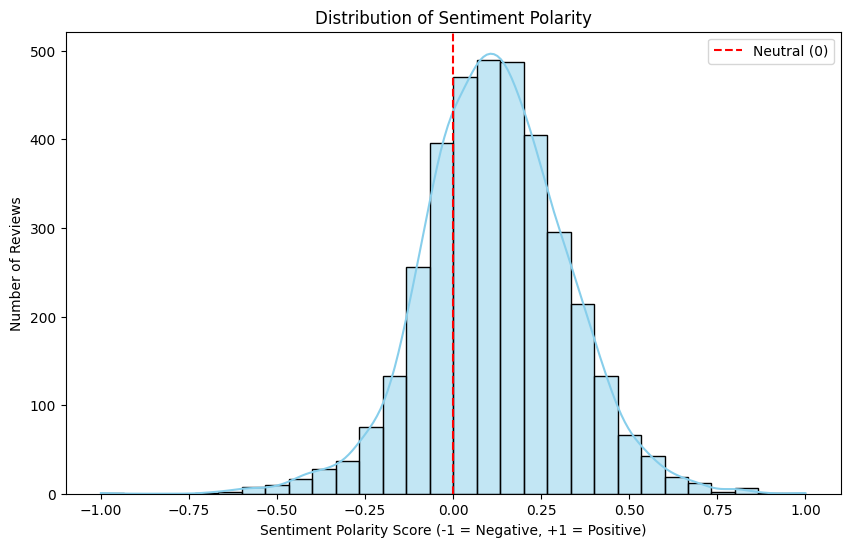

In [154]:
# Plotting the distribution of sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(reviews_cleaned['sentiment_polarity'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity Score (-1 = Negative, +1 = Positive)')
plt.ylabel('Number of Reviews')
plt.axvline(0, color='red', linestyle='--', label='Neutral (0)')
plt.legend()
plt.show()

In [155]:
# Map sentiment polarity to categories
def polarity_category(polarity):
    if polarity >= 0.25:
        return 'Positive'
    elif polarity <= -0.25:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the mapping function
reviews_cleaned['polarity_category'] = reviews_cleaned['sentiment_polarity'].apply(polarity_category)   

# Count the number of reviews in each polarity category
polarity_counts = reviews_cleaned['polarity_category'].value_counts()

polarity_counts

polarity_category
Neutral     2596
Positive     883
Negative     129
Name: count, dtype: int64

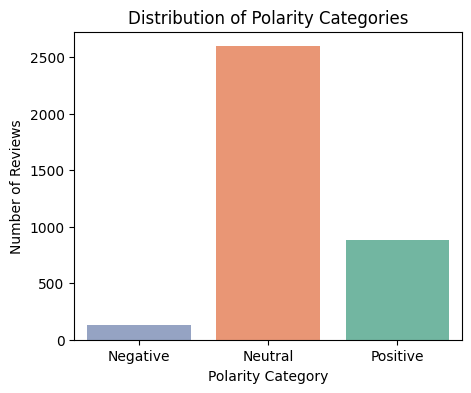

In [156]:
# Plot the polarity categories
plt.figure(figsize=(5, 4))
sns.countplot(x='polarity_category', data=reviews_cleaned, 
              palette='Set2', hue='polarity_category', 
              order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribution of Polarity Categories')
plt.xlabel('Polarity Category')
plt.ylabel('Number of Reviews')
plt.show()

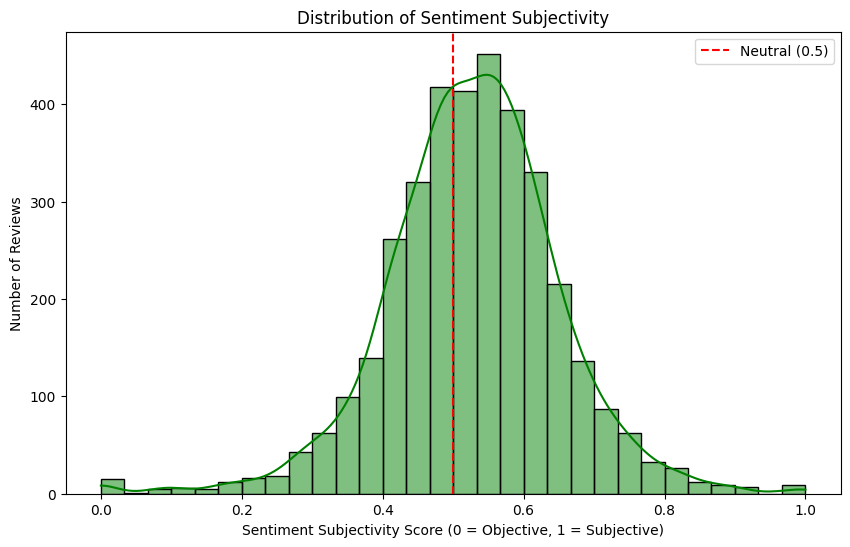

In [157]:
# Plotting the distribution of sentiment subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(reviews_cleaned['sentiment_subjectivity'], bins=30, kde=True, color='green')
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Sentiment Subjectivity Score (0 = Objective, 1 = Subjective)')
plt.ylabel('Number of Reviews')
plt.axvline(0.5, color='red', linestyle='--', label='Neutral (0.5)')
plt.legend()
plt.show()

In [158]:
# Categorize subjectivity
def subjectivity_category(subjectivity):
    if subjectivity >= 0.65:
        return 'Subjective'
    elif subjectivity <= 0.35:
        return 'Objective'
    else:
        return 'Neutral'
    
# Apply the mapping function
reviews_cleaned['subjectivity_category'] = reviews_cleaned['sentiment_subjectivity'].apply(subjectivity_category)

# Count the number of reviews in each subjectivity category
subjectivity_counts = reviews_cleaned['subjectivity_category'].value_counts()
subjectivity_counts

subjectivity_category
Neutral       2904
Subjective     484
Objective      220
Name: count, dtype: int64

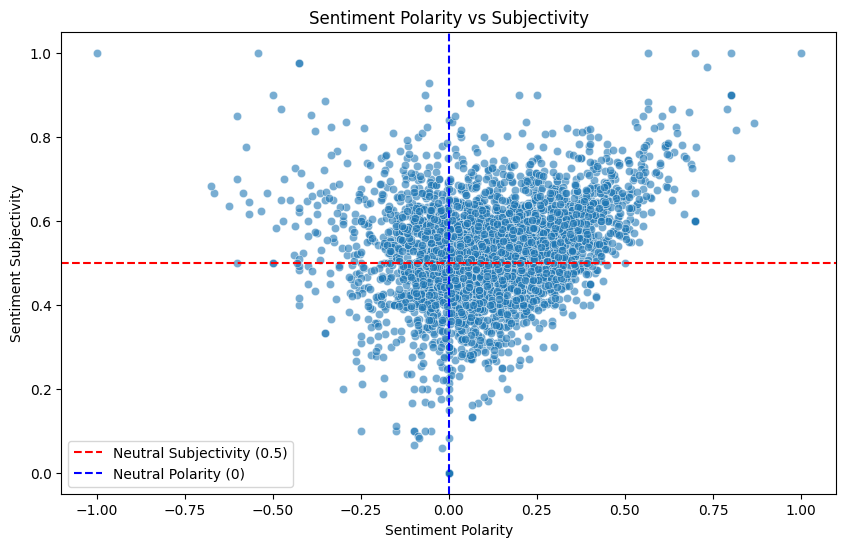

In [159]:
# Scatter plot of sentiment polarity vs subjectivity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_polarity', y='sentiment_subjectivity', data=reviews_cleaned, alpha=0.6)
plt.title('Sentiment Polarity vs Subjectivity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.axhline(0.5, color='red', linestyle='--', label='Neutral Subjectivity (0.5)')
plt.axvline(0, color='blue', linestyle='--', label='Neutral Polarity (0)')
plt.legend()
plt.show()

### Sentiment Analysis Using VADER

In [160]:
# Apply VADER sentiment analysis and extract the compound score
reviews_cleaned['vader_sentiment'] = reviews_cleaned['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
# Comparing of Textblob and Vader polarity scores
sentiment_comparison = reviews_cleaned[['sentiment_polarity', 'vader_sentiment']].describe().round(2)
sentiment_comparison

,sentiment_polarity,vader_sentiment
count,3608.00,3608.00
mean,0.12,0.31
std,0.20,0.72
min,-1.00,-1.00
25%,-0.01,-0.42
50%,0.12,0.68
75%,0.25,0.94
max,1.00,1.00


🧠 **What This Tells Us:**

🔹 **Polarity (TextBlob vs. VADER)**

* **TextBlob Polarity (mean: 0.12)** shows the reviews are slightly positive on average, but not strongly so.
* **VADER Compound (mean: 0.31)** suggests a stronger lean toward **positive sentiment** than TextBlob.
* **VADER’s 75th percentile is 0.94** — this means a large number of reviews are classified as **very positive**, more than what TextBlob detects.
* **VADER’s wider standard deviation (0.72)** reflects that it’s capturing more **extreme sentiments** — both highly negative and highly positive.

✅ **Conclusion:**
**VADER is more expressive** in detecting emotional highs and lows in informal reviews. TextBlob tends to give more **conservative scores**.

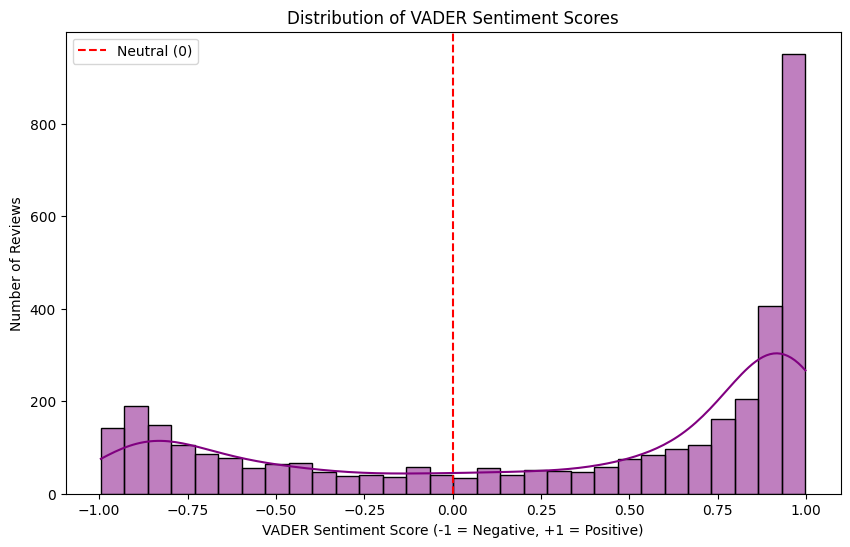

In [162]:
# Plotting the distribution of vadar sentiment
plt.figure(figsize=(10, 6))
sns.histplot(reviews_cleaned['vader_sentiment'], bins=30, kde=True, color='purple')
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score (-1 = Negative, +1 = Positive)')
plt.ylabel('Number of Reviews')
plt.axvline(0, color='red', linestyle='--', label='Neutral (0)')
plt.legend()
plt.show()

In [163]:
# Categorize VADER sentiment scores
def vader_sentiment_category(score):
    if score >= 0.25:
        return 'Positive'
    elif score <= -0.25:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the mapping function
reviews_cleaned['vader_label'] = reviews_cleaned['vader_sentiment'].apply(vader_sentiment_category)

# Count the number of reviews in each VADER polarity category
vader_polarity_counts = reviews_cleaned['vader_label'].value_counts()
vader_polarity_counts    

vader_label
Positive    2253
Negative    1028
Neutral      327
Name: count, dtype: int64

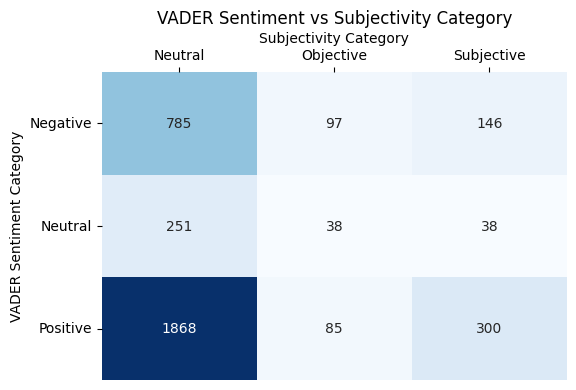

In [164]:
# Heatmap of vader sentiment vs TextBlob subjectivity
plt.figure(figsize=(6, 4))
sns.heatmap(pd.crosstab(reviews_cleaned['vader_label'], reviews_cleaned['subjectivity_category']),
            annot=True, fmt='d', cmap='Blues', cbar=False)

# Move x-axis labels to the top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

plt.yticks(rotation=0)

plt.title('VADER Sentiment vs Subjectivity Category')
plt.xlabel('Subjectivity Category')
plt.ylabel('VADER Sentiment Category')
plt.show()

### Extracting Top 5 Reviews based on each sentiment category

In [165]:
pd.set_option('display.max_colwidth', None)

In [166]:
# 1. Top 5 most positive reviews based on vader sentiment
top_positive_reviews = reviews_cleaned.nlargest(5, 'vader_sentiment')[['reviews', 'vader_sentiment']]
top_positive_reviews['vader_sentiment'] = top_positive_reviews['vader_sentiment'].round(2)

print("Top 5 Most Positive Reviews:")
top_positive_reviews


Top 5 Most Positive Reviews:


,reviews,vader_sentiment
587,"I was supposed to fly with Aeroflot on the 23rd of December to Moscow. But because Russia has closed its borders, like the majority of other countries, the flight was canceled, and I couldn’t get home. I’ve also tried to fly through Antalya, but the same situation occurred. On my third try, I came to Heathrow and tried to fly away to Cairo. I was declined by another company. Then I went to British Airways. Starting from testing (because Egypt requires tests), as stressful as the whole situation was, the employees were outstanding! (I’m not sure is it connected to BA, but still, I want to mention this). The crew was very helpful and extremely understanding, very professional and urgent to help, they have been a great help and I am very gracious for this. I want to separately point out one employee - Shanell (if I am not mistaken, who works at Collision testing center in Heathrow Terminal 5). She is a savior and most importantly a human, which is very rare nowadays! Carrying on, I went to BA check-in, but unfortunately couldn’t do it, as my results didn’t go through yet. However, another outstanding employee who provided great help called her colleagues and arranged for the booking to be frozen until the results arrive. I’ve come to her 3 times with additional questions, and every time she was very patient, professional, and happy to help. After I got my results I came back to Heathrow on 24th, but unfortunately, there were no flights to Cairo, the situation became even more complicated (I will spare the details). However, here again, brilliant employees of BA offered their personal assistance and showed sympathy and humanity towards me. The nicest lady I’ve ever met, unfortunately, I didn’t catch her name, but I am aware it was her first day at BA and that she is Egyptian, followed me throughout my struggles, offered me emotional and professional support. She tried to find any possible ways for me to get back home and actually did. She was open to any kind of help and was enormously helpful for which I can’t thank her enough. She also asked her colleague to help me, which he kindly did. Lastly, the nice lady (shame I don’t know her name) also shared my struggles with her colleague Mani who came to substitute her on the position. He was very friendly and attentive as well, talked me through the process, offered different ways I can stay at the airport, gave his phone to call, and offered to drop me off at the hotel, which he did not have to do whatsoever. To conclude, I merely want to thank all of these individuals one more time, as they have been a great help both in physical and mental aspects, I honestly do not know what would I do if I haven’t met them. I don’t know was I just lucky to meet these people or all BA employees are of the same morality, but I do want to thank BA for hiring and providing jobs for these great human beings as well as upholding the standard for other airlines! For some people, the help that was provided to me might seem like a normal thing to do. However, for me, it was a pleasant and so much needed surprise. As no one in",1.0
1334,"London to Tel Aviv. Arrived at Heathrow at about 5pm expecting it to be very busy, but check and security felt like it was 10pm, very easy and quick process (which included regular rather than fast track security as we didn’t follow the signs properly). We used galleries south lounge and first impressions were actually pretty poor, although they did later improve. The food offering on arrival was a few sandwiches, soup and some dry cake. This wasn’t really acceptable at all although about an hour after we arrived the evening meals were laid out and there was a good selection of hot and cold dishes which were quite tasty. Drinks overall were good as always with British Airways although champagne is only served on request and the quality of the one provided was really quite appalling. In terms of seating, there was enough for all the passengers

In [167]:
# 2. Top 5 most negative reviews based on vader sentiment
top_negative_reviews = reviews_cleaned.nsmallest(5, 'vader_sentiment')[['reviews', 'vader_sentiment']]
top_negative_reviews['vader_sentiment'] = top_negative_reviews['vader_sentiment'].round(2)

print("Top 5 Most Negative Reviews:")
top_negative_reviews

Top 5 Most Negative Reviews:


,reviews,vader_sentiment
768,"Hong Kong to Copenhagen via London. The whole experience is a nightmare to me and my wife. My wife lost her luggage ever since the first day of our journey on 1st August because our two pieces of luggage were left in Heathrow Airport by BA staff when we took the transit flight from the UK to Copenhagen. We went to Menzies in CPH and they filed a repor. We stated in the missing report that if the luggage was found, they should be sent to our air b&b house in Marstal in CPH on or before 3rd August or deliver to the hotel we stayed in CPH if they were found on 4th August. On 2nd August, we found that the updated status of our missing luggage in the BA website showed that one of our luggage was found while another one had a possible match. Therefore, we kept phoning and emailing Menzies staff to urge them to send the luggage to our house but they failed to do so. And the website status showed that we chose to pick up the luggage in the airport, which was not our preference but we failed to change the preference on the website as it was preset. The system even changed the latest delivery date to 3th August 2020 instead of 2019 and we could not correct it by ourselves! On 3rd August, Menzies staff still failed to deliver the luggage to us so we told them we decided to pick them up at the airport. Unfortunately, when we went to the CPH airport on the 4th August, they told us that they had already sent the 'found' luggage to the island in Marstal on 4th. Apparently they did not follow our instructions and sent it to the wrong place on the wrong date. They then asked us to find the other luggage that had been scanned with a possible match randomly in the trolleys outside their office. We did find the other one by ourselves in the airport, which they claimed had been sent to the island but they insisted that it was the possible match one! They were so incompetent and even asked us to complain to the BA to push them to find the baggage for us. We believe that the baggage was the one which was sent to the island but is still missing but the staff messed it up. We were so confused which bag was really missing. We finally decided to ask them to deliver the luggage in Marstal to the airport and send it to the UK address which was our next destination. When we came back to the hotel in the evening on the 4th, we phoned Menzies again and found out that our luggage in Marstal had been sent back to the airport at 8 pm on the 4th. Hence, we decided to pick it up by ourselves on the 5th August before we flew to the UK. However, when we came to the airport again, we couldn't find our luggage and the staff didn't explain why and just told us to leave. If the luggage was sent it to the airport on the 4th, how come it would disappear on the 5th? The staff just kept saying that they were busy and that no one had time to look for the baggage for us. This service was totally unacceptable. We spnet hours parking at the airport and found that we got nothing! You can't imagine how furious and frustrated we were! We are literally sick of phoning Menzies staff every day and not getting anywhere. Now that Menzies staff asked us to pressure BA to in turn pressure them to locate our luggage. That's how ridiculous things have been for us. We are sure that you could do something about it. My wife has lost all her personal belongings since day 1 of our trip.",-1.00
1453,"Toulouse to London Heathrow. This airline will one day get its comeuppance for posing as a quality flag carrier (it has to be said, no expense is spared on its branding) while operating as a cheap and sleazy budget airline, thanks to the rationale of its greedy and cynical new management. I have Bronze status with BA Executive Club, have flown a dozen times over the past year (both in Business and in Economy) and am increasingly irritated with myself that I chose to collect points with this particular airline. I was caught up in the IT meltdown in May (flying from Rhod

In [168]:
# 3. Top 5 most neutral reviews based on vader sentiment
top_neutral_reviews = reviews_cleaned.iloc[(reviews_cleaned['vader_sentiment'] - 0).abs().argsort()[:5]][['reviews', 'vader_sentiment']]
top_neutral_reviews['vader_sentiment'] = top_neutral_reviews['vader_sentiment'].round(2)

print("Top 5 Most Neutral Reviews:")
top_neutral_reviews

Top 5 Most Neutral Reviews:


,reviews,vader_sentiment
391,"British Airways is late, their website is atrocious, and they wouldn't let me check-in until 24 hours before the flight. I have been trying for 6 hours to check in through their website, and/or find a real person to speak with. Customer service had such a thick accent I didn't think they were speaking English.",0.0
2850,"FRA-LHR on A319, We sat on the plane at the gate for almost 40 minutes due to one runway closed, no drinks offered. No veg meal for my wife, Empty bottle under the middle seat tray. Landed allegedly almost on time due to the excessive time scheduled for the leg.",0.0
2962,Substandard food in Business Class (London to Mauritius) arbitrary upgrade policy - as we could not afford Bus Class on return flight booked Premium Economy we told that because we were Bus on way out we would get priority consideration on way back. Charging for Seat selection is a rip off was separated from my wife on way out!,0.0
2980,Return LHR-YVR Boeing 747-400. I had been advised to fly BA but unfortunately I ended up very disappointed with the return leg. My seat was double booked so they eventually got me one but the entertainment system was not working! When I asked about it she said it had not been working yesterday either. No other vacant seats in economy but there were loads in business class but would not upgrade me. 10hr flight with nothing. Definitely would not fly with them again.,0.0
1187,"Gatwick to Barbados in December 2017. On a 9 hour flight they provided one meal, and afternoon tea which consisted of a mars bar and a cup of tea. The plane was aging and yellowing round the edges and the staff were surly. The only redeeming thing was that it was cheaper than competitors (but still not cheap).",0.0


In [169]:
# 4. Top 5 most subjective reviews based on TextBlob subjectivity
top_subjective_reviews = reviews_cleaned.nlargest(5, 'sentiment_subjectivity')[['reviews', 'sentiment_subjectivity']]
top_subjective_reviews['sentiment_subjectivity'] = top_subjective_reviews['sentiment_subjectivity'].round(2)

print("Top 5 Most Subjective Reviews:")
top_subjective_reviews

Top 5 Most Subjective Reviews:


,reviews,sentiment_subjectivity
2,"Terrible experience. No respect to priority boarding, crowded buses to take us to plane, without to mention the waiting time we had to wait inside the switched off bus with NO air conditioning.",1.0
591,"Boarding and checkin formalities are very nice. Check in help desk was very helpful and supportive. Everything was nice except food. I am vegan and there was no food availability for vegetarian passengers if not pre-ordered. My flight was 10 hour journey from London to Bangalore, and I was hungry.",1.0
698,"Los Angeles to Amsterdam via London. Due to delayed take off I risked missing my connecting flight. Thanks to the excellent premium host service, Julie and her colleague, I managed to be on time! Thank you very much.",1.0
871,"Vancouver to London, we were upgraded to business class at the airport. The staff were absolutely delightful and had a fabulous trip. Really they could not have been more helpful and I would recommend them.",1.0
1577,"Geneva to Dallas via Heathrow. I checked online and confirmed I had two bags of allowance to check in with my premium economy seat purchased. However, when I went to the airport to check in the luggage BA insisted that I only had one bag allowance and I had to pay. I had no other choice so I paid. I checked with BA in Heathrow and they confirmed I had two bags. Now I will have to go through sending the customer service a letter to get a refund. Not happy that their system is not in coordinance with each other.",1.0


In [170]:
# 6. Top 5 most objective reviews based on TextBlob subjectivity
top_objective_reviews = reviews_cleaned.nsmallest(5, 'sentiment_subjectivity')[['reviews', 'sentiment_subjectivity']]
top_objective_reviews['sentiment_subjectivity'] = top_objective_reviews['sentiment_subjectivity'].round(2)

print("Top 5 Most Objective Reviews:")
top_objective_reviews

Top 5 Most Objective Reviews:


,reviews,sentiment_subjectivity
31,"British airways lost bags in LHR then found them. Sent to Cologne where it sat for two days before they told me, but no one was there to give it to me. I spent 10 days in Europe without a bag, bought clothes. BA refused to reimburse me. They closed the case 10 days after i returned to the states when my bag showed up at my front door. They wont let you talk to management, they say they email mail you but they don't then you call customer service. they say they will escalate it but you will never know. they don't update the claims or the forms.",0.0
74,"Flight changed just one day before from British Airways to Titan. Flight delayed 2 hours. No meal served, and no entertainment. Again the flight changed to Titan for the way back.",0.0
236,"In June my flight was cancelled within three hours of departure. Was given a rebooking the next day and they lost my suitcase. It arrived three days later. Today - 25th August 2023 - it happened again. Offer of rebooking in two days. When trying to post a claim, the website doesn't work. Never again, BA.",0.0
264,Came from Glasgow to London and took connecting flight American Airlines from London to North Carolina. It's my third day here in North Carolina and still waiting for my luggage. They didn't even bother to transfer the luggage to connecting flight. Luggage are still in Glasgow.,0.0
558,"No check in staff for Economy. Never experienced this before. While Business passengers strolled up, Economy passengers were left standing for 90 mins plus.",0.0


## 2. Bag of Words and Word Frequency

### WordCloud to Identify Most Common words

In [171]:
# Combine all the reviews into one text
all_reviews = ' '.join(reviews_cleaned['lemmatized_text'])

# Tokenize the combined text into words
all_tokens = all_reviews.split()

# Count the frequency of each word
word_freq = Counter(all_tokens)

# View the 10 most common words
print("Most Common Words:", word_freq.most_common(10))

Most Common Words: [('flight', 7763), ('ba', 4730), ('seat', 4603), ('service', 2937), ('time', 2417), ('good', 2394), ('fly', 2388), ('food', 2323), ('crew', 2235), ('london', 2134)]


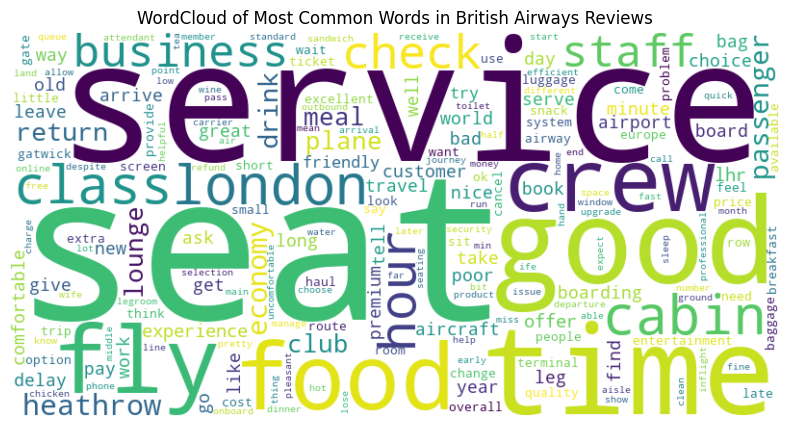

In [ ]:
# Customize the stopwords
custom_stopwords = {'british', 'airways', 'flight', 'ba', 'airline'} 
filtered_freq = {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=200).generate_from_frequencies(filtered_freq)
# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Most Common Words in British Airways Reviews')
plt.show()

### TF-IDF with Sentiment Analysis

In [173]:
# Add custom stopwords to the default English stopwords
custom_stopwords = list(default_stopwords.union({'british', 'airways', 'ba', 'airline',
                                                 'flight', 'aircraft', 'fly'}))

In [174]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords)

In [175]:
# Group by vader sentiment category and aggregate reviews
grouped_reviews = reviews_cleaned.groupby('vader_label')['lemmatized_text'].apply(lambda x: ' '.join(x))

In [176]:
# Fit and transform the grouped reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_reviews)

# Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                        index=grouped_reviews.index, 
                        columns=tfidf_vectorizer.get_feature_names_out())

In [177]:
tfidf_df.head()

,aa,able,absolute,absolutely,accept,acceptable,access,accommodate,actually,add,...,world,worth,wrap,write,wrong,year,yes,york,young,zero
vader_label,,,,,,,,,,,,,,,,,,,,,
Negative,0.005482,0.016142,0.007919,0.018274,0.010355,0.005787,0.008528,0.001523,0.014619,0.013096,...,0.040811,0.009137,0.004264,0.010355,0.024974,0.059085,0.004873,0.008223,0.006396,0.007309
Neutral,0.003174,0.029628,0.002116,0.010581,0.005291,0.006349,0.012698,0.004233,0.016930,0.007407,...,0.044441,0.014814,0.006349,0.012698,0.010581,0.049732,0.008465,0.005291,0.003174,0.001058
Positive,0.004678,0.018712,0.002782,0.008218,0.006322,0.009356,0.014034,0.003540,0.016183,0.008724,...,0.061446,0.019723,0.002276,0.005816,0.006827,0.051837,0.006954,0.007460,0.009103,0.002149


In [178]:
# View the Top 10 TF-IDF features for each sentiment category
for sentiment in grouped_reviews.index:
    print(f"\nTop 10 TF-IDF features for {sentiment} reviews:")
    top_features = tfidf_df.loc[sentiment].nlargest(10)
    print(top_features) 


Top 10 TF-IDF features for Negative reviews:
seat        0.355118
service     0.254918
hour        0.218066
london      0.211975
time        0.179691
class       0.178473
food        0.158372
business    0.148930
delay       0.147408
staff       0.145580
Name: Negative, dtype: float64

Top 10 TF-IDF features for Neutral reviews:
seat       0.417960
service    0.234904
time       0.198928
hour       0.180940
london     0.177765
food       0.175649
check      0.160835
crew       0.158719
cabin      0.157661
staff      0.146021
Name: Neutral, dtype: float64

Top 10 TF-IDF features for Positive reviews:
seat       0.384607
good       0.265761
service    0.237440
crew       0.212785
time       0.207222
food       0.206970
cabin      0.184085
london     0.160569
class      0.156523
check      0.132375
Name: Positive, dtype: float64


📊 **TF-IDF Keyword Insights by Sentiment**

To uncover more meaningful patterns beyond raw word frequency, TF-IDF was applied to the cleaned reviews. This highlights **distinctive keywords** that are especially important within each sentiment category — revealing what travelers emphasize when they’re happy, dissatisfied, or indifferent.

---

🔴 **Negative Reviews**

In negative reviews, words like **"seat"**, **"service"**, and **"delay"** stood out with high TF-IDF scores — *seat* alone had the highest emphasis across all sentiment groups. Complaints often focused on **long delays**, **uncomfortable seats**, and underwhelming **business class** experiences. Terms like *London*, *staff*, and *hour* also appeared frequently, suggesting logistical frustrations and poor customer interaction, particularly for premium passengers.

---

🟡 **Neutral Reviews**

Neutral reviews, while less emotionally charged, still revolved around practical elements like **"seat"**, **"service"**, **"check"**, and **"time"**. These reviews tend to describe experiences factually, often mentioning boarding, timing, and general expectations without strong praise or criticism. The appearance of both *crew* and *food* hints at balanced assessments — where things may not have been excellent, but also not problematic.

---

🟢 **Positive Reviews**

In contrast, positive reviews were rich with affirmations like **"good"**, **"crew"**, and **"food"**, alongside consistently frequent terms such as *seat* and *service*. Travelers in this category appreciated smooth flights, professional crew, and in some cases, premium cabin experiences. Interestingly, even in positive reviews, mentions of *London* and *check* surfaced — indicating that while the overall experience was satisfying, some key logistical touchpoints remain memorable across sentiments.

---

🧠 **Overall Takeaway**

* **“Seat” and “service”** are the most talked-about aspects across all sentiment types, showing up consistently but with different emotional tones.
* **Negative reviews** highlight operational issues and premium dissatisfaction.
* **Neutral reviews** reflect more factual, mixed experiences without emotional extremes.
* **Positive reviews** focus on friendliness, comfort, and well-executed service — with *crew* and *good* strongly associated.

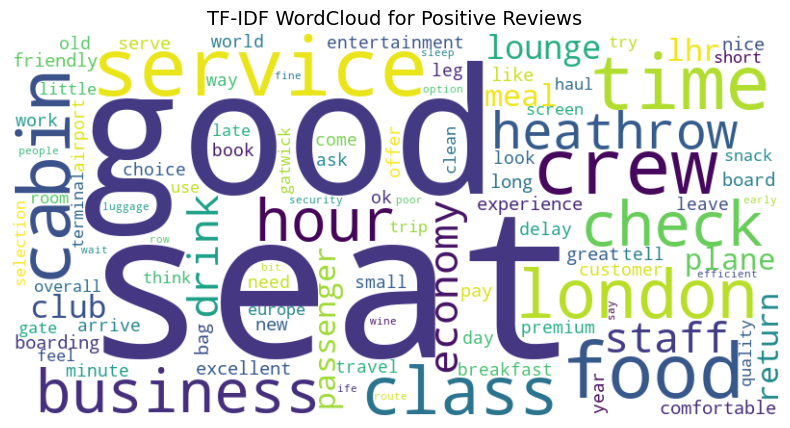

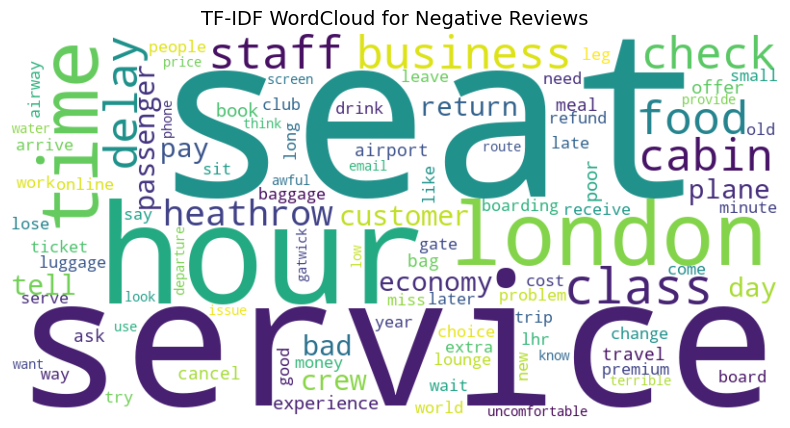

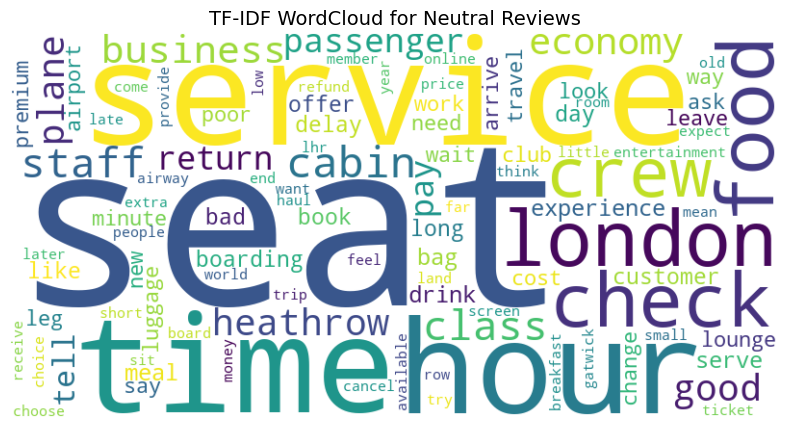

In [179]:
# Function to plot TF-IDF word cloud for a given sentiment label
def plot_tfidf_wordcloud(sentiment_label, max_words=100):
    tfidf_scores = tfidf_df.loc[sentiment_label]
    word_freq = tfidf_scores.sort_values(ascending=False).to_dict()
    
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=max_words).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"TF-IDF WordCloud for {sentiment_label} Reviews", fontsize=14)
    plt.show()

# Plot TF-IDF word clouds for each sentiment category
plot_tfidf_wordcloud("Positive")
plot_tfidf_wordcloud("Negative")
plot_tfidf_wordcloud("Neutral")


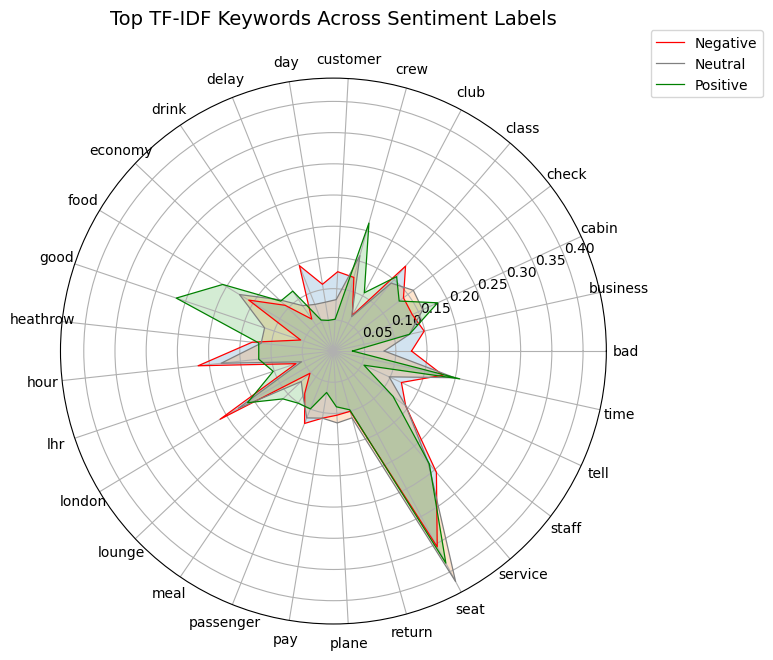

In [180]:
# Step 1: Select common or top words across all sentiments
# Here, we select top from each and take the union
top_words = set()
for sentiment in tfidf_df.index:
    top_words |= set(tfidf_df.loc[sentiment].sort_values(ascending=False).head(20).index)

# Make sure ordering is consistent
top_words = sorted(top_words)

# Step 2: Prepare data for radar plot
labels = top_words
num_vars = len(labels)

# Get the values for each sentiment
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Define custom color map
sentiment_colors = {
    'Negative': 'red',
    'Neutral': 'grey',
    'Positive': 'green'
}

# Plot each sentiment
for sentiment in tfidf_df.index:
    values = tfidf_df.loc[sentiment][labels].tolist()
    values += values[:1]  # complete the loop
    color = sentiment_colors.get(sentiment, 'blue')  # default to blue if not found
    ax.plot(angles, values, label=sentiment, color=color, linewidth=0.9)
    ax.fill(angles, values, alpha=0.2)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title("Top TF-IDF Keywords Across Sentiment Labels", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


🕸️ **TF-IDF Keyword Patterns Across Sentiment Labels (Radar Chart Insight)**

This radar chart highlights how the **importance of key review terms** varies across sentiment categories based on their TF-IDF scores.

**"Seat"** emerges as a dominant topic across all sentiments, confirming it as a central aspect of the customer experience — regardless of whether reviews are positive, neutral, or negative.

In **positive reviews**, keywords like **"crew"** and **"good"** rank highly, indicating that **staff behavior** and **overall satisfaction** are strong contributors to favorable opinions.

Conversely, **negative reviews** are more strongly associated with words such as **"delay"**, **"heathrow"**, **"hour"**, and **"lhr"** — clearly pointing to frustrations with **flight punctuality** and **airport experiences**.

Terms like **"check"**, **"service"**, and **"business"** appear more evenly across all sentiment categories, showing they are frequently mentioned but not uniquely tied to one emotional tone.

The presence of **"meal"**, **"drink"**, and **"club"** also points to references about **in-flight service and premium cabin experiences**, contributing to both **positive** and **neutral** feedback.

🧠 **Key Takeaway**:
TF-IDF analysis through radar visualization reveals both **universal themes** (e.g. seat and service) and **sentiment-specific drivers** (e.g. delays for negative reviews, crew quality for positive ones). These insights can help British Airways **prioritize improvements** and **reinforce service elements** that matter most to travelers.

<ipython-input-23-be4781cc8560>:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


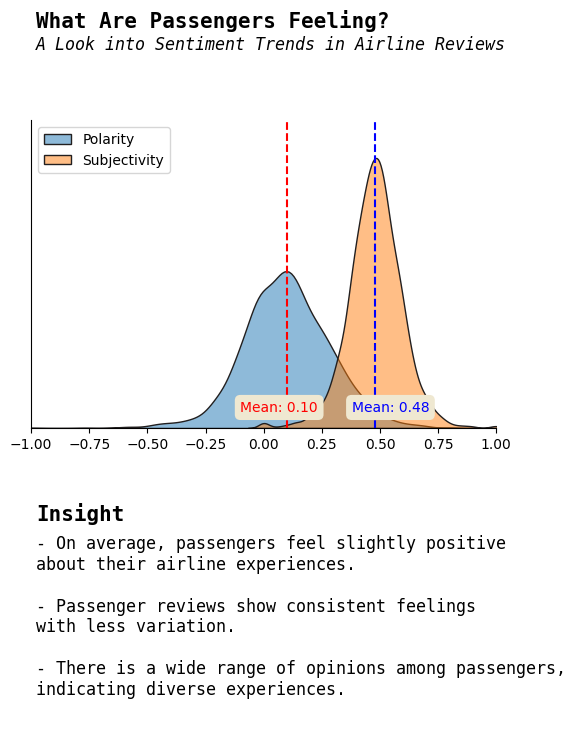

In [ ]:
# Visualizing the Polarity and Subjectivity Distribution

plt.figure(figsize=(6, 4))

# Density plots
sns.kdeplot(df['polarity'], fill=True, alpha=0.5, edgecolor='#221f1f')
sns.kdeplot(df['subjectivity'], fill=True, alpha=0.5, edgecolor='#221f1f')

# Setting x-axis and y-axis limits
plt.xlim(-1, 1)
plt.ylim(0, 4.5)

# Removing y-axis ticks and labels
plt.tick_params(left=False, labelleft=False)

# Removing ticks and spines
plt.tick_params(left=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove x and y axis labels
plt.xlabel('')
plt.ylabel('')

# Calculate and plot mean lines
mean_polarity = df['polarity'].mean()
mean_subjectivity = df['subjectivity'].mean()
plt.axvline(x=mean_polarity, color='red', linestyle='--')
plt.axvline(x=mean_subjectivity, color='blue', linestyle='--')

# Annotate mean values with a box
plt.text(mean_polarity - 0.2, 0.3, f'Mean: {mean_polarity:.2f}', color='red', va='center',
         bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0, edgecolor='none'))
plt.text(mean_subjectivity - 0.1, 0.3, f'Mean: {mean_subjectivity:.2f}', color='blue', va='center',
         bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0, edgecolor='none'))

# Adding title and subtitle
plt.text(0.01, 1.3, 'What Are Passengers Feeling?',
         fontsize=15, fontweight='bold', fontfamily='monospace', transform=plt.gca().transAxes)
plt.text(0.01, 1.23, 'A Look into Sentiment Trends in Airline Reviews',
         fontsize=12, fontweight='light', fontfamily='monospace',
         fontdict={'fontstyle': 'italic'}, transform=plt.gca().transAxes)

# Adding legends
plt.legend(['Polarity', 'Subjectivity'])

# Adding texts for insights
plt.text(0.01, -0.3, 'Insight',
         fontsize=15, fontweight='bold', fontfamily='monospace', transform=plt.gca().transAxes)

plt.text(0.01, -1, '''
- On average, passengers feel slightly positive
about their airline experiences.

- Passenger reviews show consistent feelings
with less variation.

- There is a wide range of opinions among passengers,
indicating diverse experiences.

        ''', fontsize=12, fontweight='light', fontfamily='monospace', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
# Topic Modeling to uncover themes and topics
from gensim import corpora
from gensim.models import LdaModel

In [ ]:
# Create a dictionary representation of the words
dictionary = corpora.Dictionary(df['lemmatized'].apply(str.split))

# Create a bag-of-words representation of the reviews
bow_corpus = [dictionary.doc2bow(text.split()) for text in df['lemmatized']]

# Train the LDA model
lda_model = LdaModel(bow_corpus, num_topics=6, id2word=dictionary, passes=10, random_state=42)

In [ ]:
# Display topics
topics = lda_model.print_topics(num_words=6)

# Create a dictionary to store topic labels
topic_labels = {}

# Assign labels based on the analysis of the words in each topic
topic_labels[0] = "Flight Duration and Airline Service"
topic_labels[1] = "Business Class Seating and Service"
topic_labels[2] = "Airport and Boarding Experiences"
topic_labels[3] = "Luggage and Family Travel"
topic_labels[4] = "International Routes and Economy Class"
topic_labels[5] = "General Airline and Service Feedback"

# Print topics with labels
for topic_num, topic in topics:
    label = topic_labels.get(topic_num, "No Label Assigned")
    print(f"Topic {topic_num}: {label} -> {topic}")

Topic 0: Flight Duration and Airline Service -> 0.031*"flight" + 0.021*"ba" + 0.010*"airway" + 0.010*"british" + 0.010*"hour" + 0.009*"service"
Topic 1: Business Class Seating and Service -> 0.013*"seat" + 0.013*"flight" + 0.012*"cabin" + 0.009*"crew" + 0.009*"ba" + 0.008*"food"
Topic 2: Airport and Boarding Experiences -> 0.028*"seat" + 0.014*"flight" + 0.013*"ba" + 0.011*"class" + 0.010*"economy" + 0.010*"food"
Topic 3: Luggage and Family Travel -> 0.025*"flight" + 0.012*"seat" + 0.011*"ba" + 0.010*"hour" + 0.009*"one" + 0.008*"class"
Topic 4: International Routes and Economy Class -> 0.002*"wir" + 0.002*"und" + 0.002*"zagreb" + 0.002*"war" + 0.002*"alaska" + 0.001*"worthwhile"
Topic 5: General Airline and Service Feedback -> 0.028*"flight" + 0.016*"good" + 0.015*"seat" + 0.014*"ba" + 0.013*"crew" + 0.012*"service"


In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.9 MB/s eta 0:00:00


In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# Use bow_corpus as the document-term matrix
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Assign Each Review to a Topic

# Get the dominant topic for each review
def get_dominant_topic(lda_model, bow_corpus):
    dominant_topics = []
    for i, row in enumerate(lda_model[bow_corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        dominant_topics.append(row[0][0])
    return dominant_topics

# Assign dominant topic to each review
df['dominant_topic'] = get_dominant_topic(lda_model, bow_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Group Reviews by Topic and Calculate Average Sentiment

# Calculate average polarity for each topic
topic_sentiment = df.groupby('dominant_topic')['polarity'].mean()
topic_sentiment = topic_sentiment.round(2)

# View the results
print(topic_sentiment)

dominant_topic
0    0.01
1    0.09
2    0.01
3    0.03
4    0.01
5    0.23
Name: polarity, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


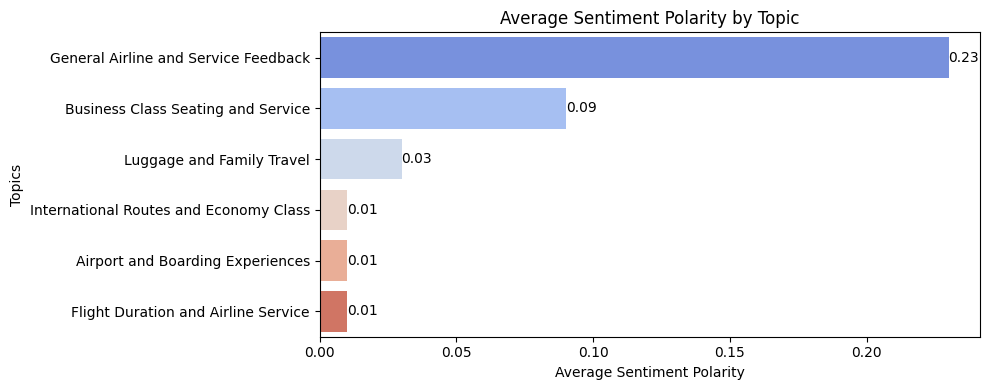

In [ ]:
import numpy as np

# Sort the data by sentiment values in descending order
sorted_idx = np.argsort(topic_sentiment)[::-1]
sorted_topics = np.array(list(topic_labels.values()))[sorted_idx]
sorted_sentiments = np.array(topic_sentiment)[sorted_idx]

# Create a color gradient
cmap = sns.color_palette("coolwarm", len(sorted_sentiments))

# Create a bar chart for average sentiment by topic
plt.figure(figsize=(10, 4))
barplot = sns.barplot(
    y=sorted_topics,
    x=sorted_sentiments,
    hue=sorted_topics,
    palette=cmap,
    dodge=False,  # Ensure all bars are shown in one color per category
    legend=False  # Disable the legend
)

# Add annotations on the bars
for i, v in enumerate(sorted_sentiments):
    barplot.text(v, i, f'{v:.2f}', color='black', va='center')

# Set chart title and labels
plt.title('Average Sentiment Polarity by Topic')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('Topics')

plt.tight_layout()
plt.show()

In [ ]:
# Create a summary table showing topics and average sentiment
summary = pd.DataFrame({
    'Topic': topic_labels.values(),
    'Average Sentiment': topic_sentiment
})

# Display the summary table
print(summary)

                                                 Topic  Average Sentiment
dominant_topic                                                           
0                  Flight Duration and Airline Service               0.01
1                   Business Class Seating and Service               0.09
2                     Airport and Boarding Experiences               0.01
3                            Luggage and Family Travel               0.03
4               International Routes and Economy Class               0.01
5                 General Airline and Service Feedback               0.23


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


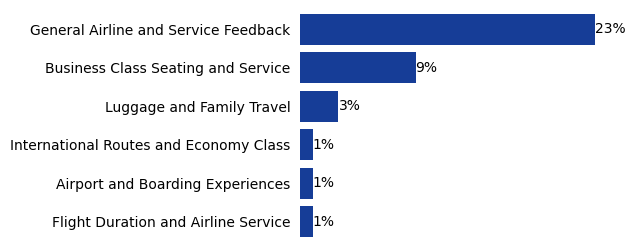

In [ ]:
# Sort the data by sentiment values in descending order
sorted_idx = np.argsort(topic_sentiment)[::-1]
sorted_topics = np.array(list(topic_labels.values()))[sorted_idx]
sorted_sentiments = np.array(topic_sentiment)[sorted_idx]

# Determine the index of the maximum sentiment value
max_idx = np.argmax(sorted_sentiments)

# Set base color and create a darker shade for the highest value
base_color = "#0035AD"  # Example base color (you can choose any color you like)
darker_color = "#0035AD"  # Darker shade of the base color

# Create a list of colors for the bars
bar_colors = [base_color] * len(sorted_sentiments)  # All bars same color
bar_colors[max_idx] = darker_color  # Darker shade for the highest value

# Create a color gradient
cmap = sns.light_palette("blue", as_cmap=False, input='xkcd', reverse=True)

# Create a bar chart for average sentiment by topic
plt.figure(figsize=(4, 3))
barplot = sns.barplot(
    y=sorted_topics,
    x=sorted_sentiments,
    hue=sorted_topics,
    palette=bar_colors,
    dodge=False,  # Ensure all bars are shown in one color per category
    legend=False,  # Disable the legend
    zorder=2
)

# Remove x and y labels
plt.xlabel('')
plt.ylabel('')

# Removing ticks and spines
plt.xticks([])
plt.tick_params(left=False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Add annotations on the bars
for i, v in enumerate(sorted_sentiments):
    barplot.text(v, i, f'{v:.0%}', color='black', va='center')

# Set chart title and labels
#plt.title('What Matters to Passengers?',
          #fontsize=13, fontweight='bold', fontfamily='monospace', transform=plt.gca().transAxes)

# Save the chart
plt.savefig('bar_topics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviews,lemmatized,polarity,subjectivity,dominant_topic
0,British Airways World Traveller Plus (Premium ...,british airway world traveller plus premium ec...,0.234242,0.536970,2
1,BA is barely a step above low cost airlines. T...,ba barely step low cost airline try dime nicke...,0.010000,0.340000,0
3,Horrible service from boarding to landing. ...,horrible service boarding landing flew london ...,-0.583333,0.883333,5
9,Absolutely atrocious. LHR-ORD-LHR Round-trip. ...,absolutely atrocious lhrordlhr roundtrip briti...,-0.069176,0.513684,2
10,As someone who flies relentlessly with British...,someone fly relentlessly british airway busine...,-0.005556,0.492593,0
...,...,...,...,...,...
3860,his was a bmi Regional operated flight on a RJ...,bmi regional operated flight rj145 manchester ...,0.061364,0.363636,3
3861,LHR to HAM. Purser addresses all club passenge...,lhr ham purser address club passenger name boa...,0.173214,0.428571,5
3862,My son who had worked for British Airways urge...,son worked british airway urged fly british ai...,0.113542,0.256250,0
3863,London City-New York JFK via Shannon on A318 b...,london citynew york jfk via shannon a318 reall...,0.340000,0.440000,5


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Initialize and fit the CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['lemmatized'])

# Extract topic words for the word cloud
num_topics = lda_model.num_topics
num_words = 20
topic_words = {}

for topic_idx in range(num_topics):
    words = lda_model.get_topic_terms(topic_idx, topn=num_words)
    feature_names = vectorizer.get_feature_names_out()
    words_arr = np.array(words) # Convert words to numpy array
    top_words_idx = words_arr[:,0].astype(int) # Convert the IDs to integers
    topic_words[topic_idx] = ' '.join([feature_names[i] for i in top_words_idx]) # Use the integer IDs to access feature names
    print(f"Topic {topic_idx}: {topic_words[topic_idx]}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0: 0289 004 001 0055 140 10272014 1020 0110 1000hrs 0005 1700 15hrs 1245pm 1125th 103 261214 1450 0510 1330 2in
Topic 1: 0710 0289 14a 0103 004 1015 1635 1372 150 101006 1000hrs 101 1100pm 1010 2013 01d 1155pm 0510 10272014 1245pm
Topic 2: 0710 0289 004 101006 01d 1015 1010 0005 0055 001 10272014 116 14a 0510 1020 1125th 0600 14k 0103 140
Topic 3: 0289 0710 004 140 0510 101006 1635 1450 1415 101 103 10in 1010 1700 090815 1245pm 1555 173 1000hrs 4244
Topic 4: critical cried jumpseat crispy everyone manchester cradle established cranky critic 1810 gviio 777300 evian outdone embarking paced contain creature cramming
Topic 5: 0289 150 0710 004 0103 10272014 1015 1000hrs 14a 1155pm 1372 14k 1955 1020 261214 1100pm 0200 11am 101006 290914


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
